---
## 1. Configuration de l'Environnement

On commence par vérifier la version de PyTorch et installer les dépendances nécessaires pour PyTorch Geometric.

In [1]:
import torch
from torch import Tensor
import numpy as np
import pandas as pd

print(f"Version de PyTorch: {torch.__version__}")

Version de PyTorch: 2.2.2+cpu


### Installation de PyTorch Geometric

PyTorch Geometric (PyG) est une bibliothèque pour le deep learning sur graphes. On installe les composants nécessaires :
- `torch-scatter` : opérations de scatter efficaces
- `torch-sparse` : algèbre linéaire sparse
- `pyg-lib` : utilitaires bas-niveau
- `pytorch_geometric` : bibliothèque principale

In [2]:
import os
os.environ['TORCH'] = torch.__version__

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/nightly/torch-2.2.2+cpu.html
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-569wqo1s
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-569wqo1s
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit a4271c4ffae4ebae96e4b85e9f4bc516dfcd76e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Import des bibliothèques

On importe toutes les bibliothèques nécessaires pour :
- Manipulation de données (pandas)
- Deep learning (torch)
- Graph Neural Networks (torch_geometric)
- Métriques et visualisation (sklearn, matplotlib)

In [3]:
from torch_geometric.data import download_url, extract_zip
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit, ToUndirected
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score
from torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt

print("✓ Toutes les bibliothèques sont importées")

✓ Toutes les bibliothèques sont importées


---
## 2. Chargement et Exploration des Données

Le **FlavorGraph** est un graphe de connaissances culinaires qui contient :
- Des **nœuds** : ingrédients, recettes, composés chimiques
- Des **arêtes** : relations entre ces éléments avec un score de compatibilité

Pour ce projet, on se concentre uniquement sur les relations **ingrédient-ingrédient**.

### Chargement des arêtes (edges)

Chaque arête représente une relation entre deux éléments avec :
- `id_1`, `id_2` : identifiants des nœuds connectés
- `edge_type` : type de relation
- `score` : force de la relation (0-1)

In [4]:
edge_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/edges_191120.csv"
edges_df = pd.read_csv(edge_url)

print("Distribution des types d'arêtes:")
print(edges_df.edge_type.value_counts())
print(f"\nNombre total d'arêtes: {len(edges_df)}")

Distribution des types d'arêtes:
edge_type
ingr-ingr     111355
ingr-fcomp     35440
ingr-dcomp       384
Name: count, dtype: int64

Nombre total d'arêtes: 147179


### Filtrage : uniquement les relations ingrédient-ingrédient

On ne garde que les 111,355 premières lignes qui correspondent aux relations ingrédient-ingrédient (`entity_entity`). Cela simplifie le problème et se concentre sur les paires d'ingrédients.

In [5]:
# Filtrer uniquement les relations entity_entity (ingrédient-ingrédient)
edges_df = edges_df.iloc[:111355, :]

print("Après filtrage:")
print(edges_df.edge_type.value_counts())
print(f"\nAperçu des données:")
edges_df.head()

Après filtrage:
edge_type
ingr-ingr    111355
Name: count, dtype: int64

Aperçu des données:


,id_1,id_2,score,edge_type
0,5063,6083,0.337742,ingr-ingr
1,244,4620,0.093855,ingr-ingr
2,2253,6753,0.107870,ingr-ingr
3,2813,6228,0.092569,ingr-ingr
4,3016,6314,0.123897,ingr-ingr


### Chargement des nœuds (nodes)

Chaque nœud contient :
- `node_id` : identifiant unique
- `name` : nom de l'ingrédient/recette/composé
- `node_type` : type du nœud

In [6]:
node_url = "https://raw.githubusercontent.com/lamypark/FlavorGraph/master/input/nodes_191120.csv"
nodes_df = pd.read_csv(node_url)

print(f"Forme du DataFrame: {nodes_df.shape}")
print("\nAperçu des nœuds:")
nodes_df.head()

Forme du DataFrame: (8298, 5)

Aperçu des nœuds:


,node_id,name,id,node_type,is_hub
0,0,1%_fat_buttermilk,NaN,ingredient,no_hub
1,1,1%_fat_cottage_cheese,NaN,ingredient,no_hub
2,3,10%_cream,NaN,ingredient,no_hub
3,4,100%_bran,NaN,ingredient,no_hub
4,5,10_inch_flour_tortilla,NaN,ingredient,no_hub


### Analyse des types de nœuds

In [7]:
print("Distribution des types de nœuds:")
nodes_df.node_type.value_counts()

Distribution des types de nœuds:


node_type
ingredient    6653
compound      1645
Name: count, dtype: int64

### Filtrage des nœuds pertinents

On ne garde que les nœuds (ingrédients) qui apparaissent dans nos arêtes filtrées.

In [8]:
# Récupérer tous les IDs uniques présents dans les arêtes
relevant_node_ids = set(edges_df.id_1.values).union(set(edges_df.id_2.values))

# Filtrer le DataFrame des nœuds
nodes_df = nodes_df[nodes_df['node_id'].isin(relevant_node_ids)]

print(f"Nombre de nœuds après filtrage: {len(nodes_df)}")
print("\nTypes de nœuds restants:")
nodes_df.node_type.value_counts()

Nombre de nœuds après filtrage: 6653

Types de nœuds restants:


node_type
ingredient    6653
Name: count, dtype: int64

---
## 3. Construction du Graphe

On construit maintenant un objet `Data` de PyTorch Geometric qui représente notre graphe.

### Étapes :
1. Créer un mapping des IDs de nœuds vers des indices contigus (0, 1, 2, ...)
2. Convertir les arêtes en format PyTorch (tenseurs)
3. Créer un graphe non-orienté (undirected)
4. Diviser en ensembles train/validation/test

In [9]:
# Initialisation du graphe
flavorGraph = Data()

# Extraction des poids des arêtes
edge_weight = torch.Tensor(edges_df.score.values)

# Extraction des indices de nœuds
node_index = torch.Tensor(nodes_df.node_id.values)

# Création d'un mapping : node_id -> index continu
node_map = dict()
for i in range(len(node_index)):
    node_map[int(node_index[i])] = i

print(f"Nombre de nœuds: {len(node_map)}")
print(f"Exemple de mapping: {list(node_map.items())[:5]}")

Nombre de nœuds: 6653
Exemple de mapping: [(0, 0), (1, 1), (3, 2), (4, 3), (5, 4)]


### Création de la matrice d'adjacence

Format PyG : `edge_index` est une matrice 2×N où chaque colonne est une arête [source, destination]

In [10]:
# Conversion des IDs d'arêtes vers les indices mappés
edge_index = torch.Tensor([
    edges_df.id_1.apply(lambda x: node_map[x]).values,
    edges_df.id_2.apply(lambda x: node_map[x]).values
])

# Construction du graphe
flavorGraph.x = node_index.view(node_index.size(0), -1)  # Features = node_id
flavorGraph.edge_index = edge_index.type(torch.int64)
flavorGraph.edge_weight = edge_weight

# Validation du graphe
flavorGraph.validate(raise_on_error=True)
print("✓ Graphe validé")

# Conversion en graphe non-orienté
flavorGraph = ToUndirected()(flavorGraph)
print(f"✓ Graphe non-orienté: {flavorGraph.is_undirected()}")
print(f"\nStatistiques du graphe:")
print(f"  - Nœuds: {flavorGraph.num_nodes}")
print(f"  - Arêtes: {flavorGraph.num_edges}")

✓ Graphe validé
✓ Graphe non-orienté: True

Statistiques du graphe:
  - Nœuds: 6653
  - Arêtes: 222710


/tmp/ipykernel_45287/2343651461.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  edge_index = torch.Tensor([


### Division Train/Validation/Test

**RandomLinkSplit** divise les arêtes du graphe en trois ensembles :
- **Train** : pour entraîner le modèle
- **Validation** : pour ajuster les hyperparamètres
- **Test** : pour évaluer les performances finales

Paramètres :
- `is_undirected=True` : graphe non-orienté
- `add_negative_train_samples=False` : on générera les samples négatifs nous-mêmes
- `disjoint_train_ratio=0.35` : 35% des arêtes pour validation/test

In [11]:
transform = RandomLinkSplit(
    is_undirected=True,
    add_negative_train_samples=False,
    disjoint_train_ratio=0.35
)

train_data, val_data, test_data = transform(flavorGraph)

print("Division des données:")
print(f"  - Train: {train_data.edge_label_index.size(1)} arêtes positives")
print(f"  - Validation: {val_data.edge_label_index.size(1)} arêtes")
print(f"  - Test: {test_data.edge_label_index.size(1)} arêtes")

Division des données:
  - Train: 27282 arêtes positives
  - Validation: 22270 arêtes
  - Test: 44542 arêtes


### Aperçu des données d'entraînement

In [12]:
print("Structure de train_data:")
print(train_data)
print("\nStructure de val_data:")
print(val_data)
print("\nStructure de test_data:")
print(test_data)

Structure de train_data:
Data(x=[6653, 1], edge_index=[2, 101334], edge_weight=[101334], edge_label=[27282], edge_label_index=[2, 27282])

Structure de val_data:
Data(x=[6653, 1], edge_index=[2, 155898], edge_weight=[155898], edge_label=[22270], edge_label_index=[2, 22270])

Structure de test_data:
Data(x=[6653, 1], edge_index=[2, 178168], edge_weight=[178168], edge_label=[44542], edge_label_index=[2, 44542])


---
## 4. Modèle GCN (Graph Convolutional Network)

### Architecture du modèle

Le **GCN** fonctionne en deux étapes :

1. **Encodage** : Deux couches de convolution sur graphe qui agrègent les informations des voisins
   - Couche 1 : `num_features → 128 dimensions`
   - Couche 2 : `128 → 64 dimensions` (embeddings finaux)

2. **Décodage** : Prédit la probabilité d'existence d'une arête par produit scalaire des embeddings
   - Si `z[i] · z[j]` est élevé → l'arête (i,j) existe probablement

### Fonctions clés
- `encode()` : transforme le graphe en embeddings
- `decode()` : prédit des arêtes à partir des embeddings
- `decode_all()` : calcule toutes les probabilités d'arêtes possibles

In [13]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Deux couches de convolution sur graphe
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        """Encode le graphe en embeddings de dimension out_channels"""
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        """Prédit la probabilité d'arêtes spécifiques via produit scalaire"""
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        """Calcule la matrice complète de probabilités d'arêtes"""
        prob_adj = z @ z.t()  # Produit matriciel : NxD × DxN = NxN
        prob_adj = torch.sigmoid(prob_adj)  # Conversion en probabilités [0,1]
        return prob_adj

print("✓ Classe Net (GCN) définie")

✓ Classe Net (GCN) définie


### Initialisation du modèle GCN

- **Entrée** : 1 feature (node_id)
- **Couche cachée** : 128 dimensions
- **Sortie** : 64 dimensions (embeddings)
- **Optimiseur** : Adam avec learning rate 0.01
- **Loss** : Binary Cross Entropy with Logits (pour classification binaire)

In [14]:
# Initialisation
model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print(f"Modèle GCN initialisé:")
print(f"  - Features d'entrée: {flavorGraph.num_features}")
print(f"  - Dimensions cachées: 128")
print(f"  - Dimensions de sortie: 64")
print(f"  - Paramètres totaux: {sum(p.numel() for p in model.parameters())}")

Modèle GCN initialisé:
  - Features d'entrée: 1
  - Dimensions cachées: 128
  - Dimensions de sortie: 64
  - Paramètres totaux: 8512


### Fonctions d'entraînement et d'évaluation

**Entraînement** :
1. Encode le graphe
2. Génère des arêtes négatives (échantillonnage aléatoire)
3. Calcule la loss sur arêtes positives + négatives
4. Backpropagation et mise à jour des poids

**Évaluation** :
- Métrique : **ROC-AUC** (Area Under ROC Curve)
- Mesure la capacité à distinguer arêtes existantes vs. inexistantes

In [15]:
def train():
    model.train()
    optimizer.zero_grad()
    
    # Encodage du graphe
    z = model.encode(train_data.x, train_data.edge_index)

    # Échantillonnage négatif : génère des arêtes qui n'existent pas
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method='sparse'
    )

    # Concaténation arêtes positives + négatives
    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    # Prédiction et calcul de la loss
    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    return loss


@torch.no_grad()
def test(data):
    """Évalue le modèle avec la métrique ROC-AUC"""
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    
    # Calcul ROC-AUC
    y = data.edge_label.cpu().numpy()
    pred = out.cpu().numpy()
    return roc_auc_score(y, pred)

print("✓ Fonctions train() et test() définies")

✓ Fonctions train() et test() définies


### Entraînement du modèle GCN

On entraîne pendant **150 epochs** et on sauvegarde :
- Les métriques de validation et test à chaque epoch
- Le meilleur modèle basé sur la validation
- Les probabilités finales pour toutes les paires d'ingrédients

In [ ]:
validationMetrics_GCN = []
best_val_auc = final_test_auc = 0

print("Début de l'entraînement GCN...\n")

for epoch in range(1, 151):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    # Sauvegarde du meilleur modèle
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_GCN.append([val_auc, test_auc])
    
    # Affichage tous les 10 epochs
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nEntraînement terminé')
print(f'Meilleur Test AUC: {final_test_auc:.4f}')

# Calcul des probabilités finales
z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_GCN = model.decode_all(z)
print(f'Matrice de probabilités calculée: {final_edge_probs_GCN.shape}')

Début de l'entraînement GCN...

Epoch: 001, Loss: 3451506.2500, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 162726.9531, Val: 0.5000, Test: 0.5000
Epoch: 020, Loss: 64612.6484, Val: 0.5000, Test: 0.5000
Epoch: 030, Loss: 25346.9961, Val: 0.5000, Test: 0.5000
Epoch: 040, Loss: 4867.8003, Val: 0.5000, Test: 0.5001
Epoch: 050, Loss: 2705.1934, Val: 0.5001, Test: 0.5003
Epoch: 060, Loss: 585.5106, Val: 0.5001, Test: 0.5002
Epoch: 070, Loss: 334.5504, Val: 0.5001, Test: 0.5003
Epoch: 080, Loss: 104.0571, Val: 0.5011, Test: 0.5008
Epoch: 090, Loss: 34.1343, Val: 0.5081, Test: 0.5095
Epoch: 100, Loss: 14.8320, Val: 0.5898, Test: 0.5951
Epoch: 110, Loss: 4.0810, Val: 0.8461, Test: 0.8496
Epoch: 120, Loss: 1.6432, Val: 0.8413, Test: 0.8445
Epoch: 130, Loss: 0.8313, Val: 0.8463, Test: 0.8489
Epoch: 140, Loss: 0.6884, Val: 0.8502, Test: 0.8518
Epoch: 150, Loss: 0.6543, Val: 0.8905, Test: 0.8936

✓ Entraînement terminé
📊 Meilleur Test AUC: 0.8936
✓ Matrice de probabilités calculée: torch.Size([665

### Visualisation des performances GCN

Courbe d'évolution du **Test AUC** au fil des epochs.

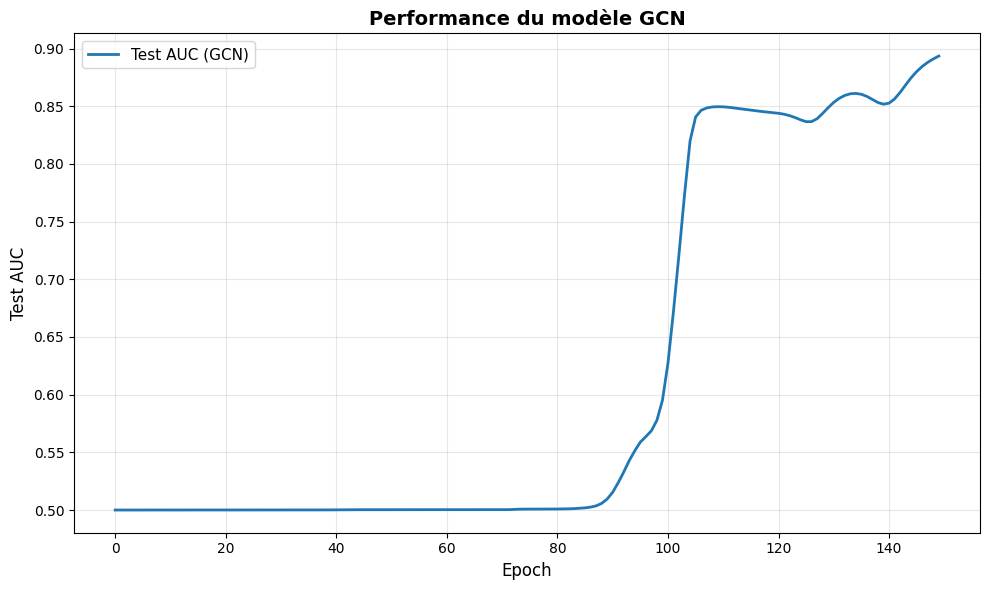

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='Test AUC (GCN)', 
         linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GCN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GCN)

On part d'un ingrédient aléatoire et on suit les liens les plus probables pour créer une "recette" de 2-6 ingrédients.

In [ ]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GCN:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    # Top 10 ingrédients les plus compatibles
    top_nodes = nodes_df.iloc[final_edge_probs_GCN.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

🍳 Recette générée avec GCN:
Ingrédient de départ: dried_cannellini_bean

  1. milk
  2. water


---
## 5. Modèle GraphSAGE

### Différences avec GCN

**GraphSAGE** (SAmple and aggreGatE) diffère du GCN par :
1. **Échantillonnage** : ne considère qu'un sous-ensemble de voisins (scalabilité)
2. **Agrégation** : plus flexible (mean, max, LSTM, etc.)
3. **Généralisation** : meilleure sur de nouveaux nœuds (inductive learning)

Dans PyG, `SAGEConv` utilise l'agrégation par moyenne.

In [19]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        # Remplacement des couches GCN par SAGEConv
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        prob_adj = torch.sigmoid(prob_adj)
        return prob_adj

print("✓ Classe Net (GraphSAGE) définie")

✓ Classe Net (GraphSAGE) définie


### Initialisation du modèle GraphSAGE

Même architecture que GCN : 1 → 128 → 64

In [20]:
model = Net(flavorGraph.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

print(f"Modèle GraphSAGE initialisé:")
print(f"  - Paramètres totaux: {sum(p.numel() for p in model.parameters())}")

Modèle GraphSAGE initialisé:
  - Paramètres totaux: 16832


### Entraînement du modèle GraphSAGE

Même procédure que pour GCN : 150 epochs avec suivi des métriques.

In [ ]:
validationMetrics_SAGE = []
best_val_auc = final_test_auc = 0

print("Début de l'entraînement GraphSAGE...\n")

for epoch in range(1, 151):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        final_test_auc = test_auc
    
    validationMetrics_SAGE.append([val_auc, test_auc])
    
    if epoch % 10 == 0 or epoch == 1:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, Test: {test_auc:.4f}')

print(f'\nEntraînement terminé')
print(f'Meilleur Test AUC: {final_test_auc:.4f}')

z = model.encode(test_data.x, test_data.edge_index)
final_edge_probs_SAGE = model.decode_all(z)
print(f'Matrice de probabilités calculée: {final_edge_probs_SAGE.shape}')

Début de l'entraînement GraphSAGE...

Epoch: 001, Loss: 90515832.0000, Val: 0.5000, Test: 0.5000
Epoch: 010, Loss: 35134436.0000, Val: 0.5022, Test: 0.5009
Epoch: 020, Loss: 4022175.5000, Val: 0.5075, Test: 0.5053
Epoch: 030, Loss: 2639097.2500, Val: 0.5078, Test: 0.5059
Epoch: 040, Loss: 1020273.6250, Val: 0.5211, Test: 0.5205
Epoch: 050, Loss: 371019.6250, Val: 0.5315, Test: 0.5297
Epoch: 060, Loss: 245264.1406, Val: 0.5301, Test: 0.5309
Epoch: 070, Loss: 128862.4062, Val: 0.5307, Test: 0.5345
Epoch: 080, Loss: 90669.9453, Val: 0.5362, Test: 0.5371
Epoch: 090, Loss: 63816.7305, Val: 0.5319, Test: 0.5342
Epoch: 100, Loss: 46008.4414, Val: 0.5299, Test: 0.5351
Epoch: 110, Loss: 35371.6016, Val: 0.5327, Test: 0.5381
Epoch: 120, Loss: 28748.7441, Val: 0.5384, Test: 0.5406
Epoch: 130, Loss: 24547.2637, Val: 0.5371, Test: 0.5411
Epoch: 140, Loss: 20657.2188, Val: 0.5385, Test: 0.5413
Epoch: 150, Loss: 18431.1680, Val: 0.5398, Test: 0.5411

✓ Entraînement terminé
📊 Meilleur Test AUC: 0.5430

### Visualisation des performances GraphSAGE

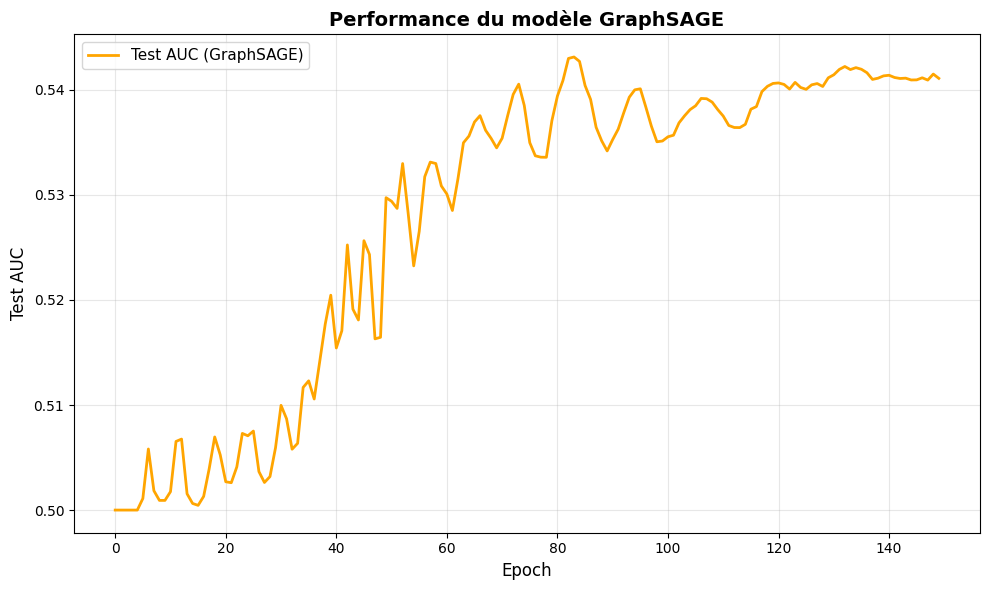

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='Test AUC (GraphSAGE)', 
         linewidth=2,
         color='orange')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Test AUC', fontsize=12)
plt.title('Performance du modèle GraphSAGE', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Test : Génération d'une recette aléatoire (GraphSAGE)

In [ ]:
start_node = np.random.randint(0, len(nodes_df))
print(f"Recette générée avec GraphSAGE:")
print(f"Ingrédient de départ: {nodes_df.iloc[start_node]['name']}\n")

for i in range(1, min(np.random.poisson(4, 1)[0] + 1, 7)):
    top_nodes = nodes_df.iloc[final_edge_probs_SAGE.topk(10, dim=1).indices[start_node, ]]
    which_one = np.random.randint(0, 10)
    start_node = top_nodes.iloc[which_one].name
    print(f"  {i}. {top_nodes.iloc[which_one]['name']}")

🍳 Recette générée avec GraphSAGE:
Ingrédient de départ: consomme

  1. boil_in_the_bag_rice
  2. 6_inch_flour_tortilla


---
## 6. Comparaison des Modèles

Comparons visuellement les performances de **GCN** et **GraphSAGE** sur l'ensemble de test.

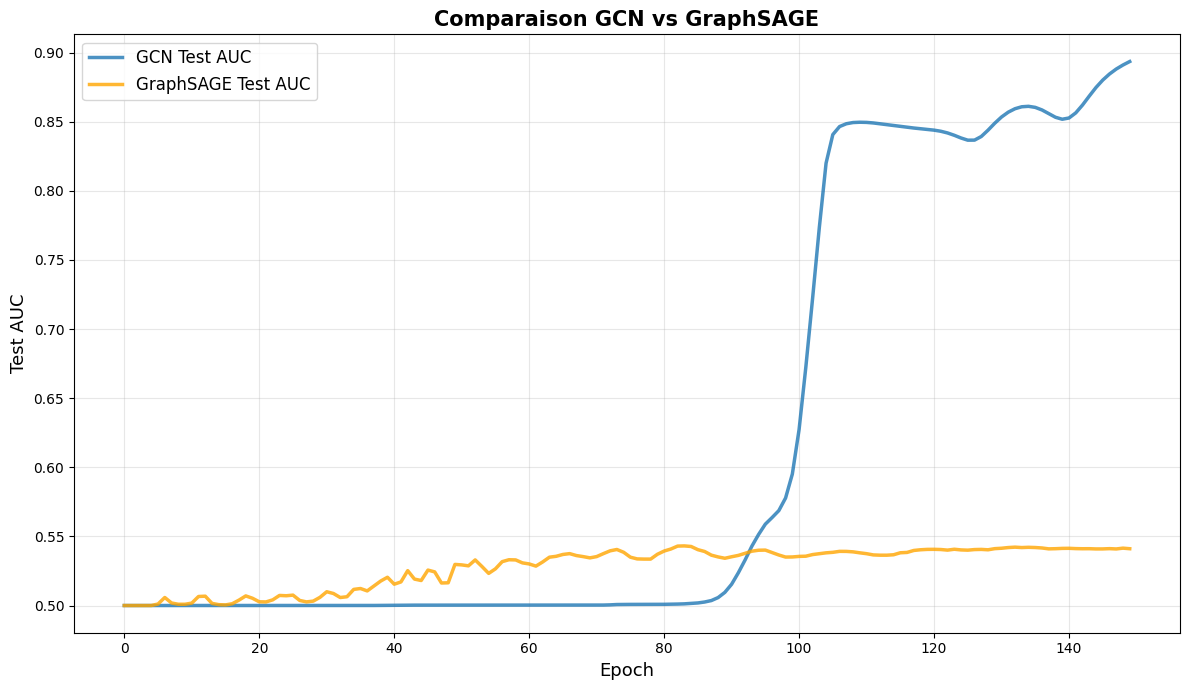


📊 Résultats Finaux:
  GCN Test AUC:        0.8936
  GraphSAGE Test AUC:  0.5411
  Différence:          0.3525

🏆 GCN performe mieux de 65.14%


In [ ]:
plt.figure(figsize=(12, 7))

plt.plot(np.arange(len(validationMetrics_GCN)), 
         np.array(validationMetrics_GCN)[:, 1], 
         label='GCN Test AUC', 
         linewidth=2.5,
         alpha=0.8)

plt.plot(np.arange(len(validationMetrics_SAGE)), 
         np.array(validationMetrics_SAGE)[:, 1], 
         label='GraphSAGE Test AUC', 
         linewidth=2.5,
         alpha=0.8,
         color='orange')

plt.xlabel('Epoch', fontsize=13)
plt.ylabel('Test AUC', fontsize=13)
plt.title('Comparaison GCN vs GraphSAGE', fontsize=15, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques finales
gcn_final = np.array(validationMetrics_GCN)[-1, 1]
sage_final = np.array(validationMetrics_SAGE)[-1, 1]

print("\nRésultats Finaux:")
print(f"  GCN Test AUC:        {gcn_final:.4f}")
print(f"  GraphSAGE Test AUC:  {sage_final:.4f}")
print(f"  Différence:          {abs(gcn_final - sage_final):.4f}")

if gcn_final > sage_final:
    print(f"\nGCN performe mieux de {((gcn_final - sage_final) / sage_final * 100):.2f}%")
else:
    print(f"\nGraphSAGE performe mieux de {((sage_final - gcn_final) / gcn_final * 100):.2f}%")

---
## Conclusion

### Résumé du projet

Nous avons implémenté deux modèles de **Graph Neural Networks** pour la prédiction de liens sur le FlavorGraph :

1. **GCN** : Modèle classique avec convolutions sur graphe
2. **GraphSAGE** : Modèle avec échantillonnage et agrégation flexible

### Métriques

Les deux modèles sont évalués avec **ROC-AUC**, qui mesure la capacité à distinguer les paires d'ingrédients compatibles des incompatibles.

### Applications possibles

- **Recommandation de recettes** : suggérer des ingrédients complémentaires
- **Découverte culinaire** : identifier des combinaisons inédites mais prometteuses
- **Analyse de cuisine** : comprendre les patterns de différentes traditions culinaires

### Améliorations possibles

1. Utiliser les **poids des arêtes** dans le modèle
2. Ajouter des **features supplémentaires** (composés chimiques, catégories)
3. Tester d'autres architectures (GAT, GIN, etc.)
4. Implémenter un **système de recommandation** interactif